In [88]:
# I want to import ais_test.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import daytime as dt

""" Notes:
- Check if all registered locations are in the sea
- help models with 360 degrees directions
- check for all nans
- Extracheck that port locations are congruent
- Add hasScheldue, whether the ship has a schedule or not
- Add boolean isInPort, whether the ship is in port or not
- Add daysSinceDeparture
- Add lastDepartureLatitude, lastDepartureLongitude
- Add daysUntilArrival
- Add nextArrivalLatitude, nextArrivalLongitude
- Normalize all numerical values
"""

ais_train = pd.read_csv('ais_train.csv', sep='|')
ais_train['time'] = pd.to_datetime(ais_train['time']).dt.tz_localize(None)
print(ais_train.shape)
ais_train.head(5)

(1522065, 11)


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.00,0.70,0,88,0,01-09 23:00,-34.74,-57.85,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.60,0.00,-6,347,1,12-29 20:00,8.89,-79.48,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.00,11.00,0,112,0,01-02 09:00,39.19,-76.48,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.40,0.00,0,142,1,12-31 20:00,-34.41,151.02,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.00,19.70,0,215,0,01-25 12:00,35.88,-5.92,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [89]:
# Add year to etaRaw and make it a datetime object
# If the month is august or later, make it 2023, else 2024
ais_train['etaRaw'] = pd.to_datetime('2024-' + ais_train['etaRaw'], format='%Y-%m-%d %H:%M', errors='coerce')
ais_train['etaRaw'] = ais_train['etaRaw'].apply(lambda x: x.replace(year=2023) if x.month > 7 else x)

ais_train.head(5)


,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.00,0.70,0,88,0,2024-01-09 23:00:00,-34.74,-57.85,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.60,0.00,-6,347,1,2023-12-29 20:00:00,8.89,-79.48,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.00,11.00,0,112,0,2024-01-02 09:00:00,39.19,-76.48,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.40,0.00,0,142,1,2023-12-31 20:00:00,-34.41,151.02,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.00,19.70,0,215,0,2024-01-25 12:00:00,35.88,-5.92,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3


In [90]:


# Show number, not 	1.522065e+06
pd.set_option('display.float_format', lambda x: '%.2f' % x)
ais_train.describe()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude
count,1522065,1522065.00,1522065.00,1522065.00,1522065.00,1522065.00,1518302,1522065.00,1522065.00
mean,2024-03-06 03:20:23.657231360,178.25,6.33,0.51,176.27,2.09,2024-03-05 13:55:54.755825920,36.58,11.54
min,2024-01-01 00:00:25,0.00,0.00,-127.00,0.00,0.00,2023-08-01 08:30:00,-47.53,-167.54
25%,2024-02-03 02:59:19,78.20,0.00,0.00,75.00,0.00,2024-02-02 12:00:00,34.52,-5.21
50%,2024-03-07 12:34:57,183.80,0.50,0.00,180.00,0.00,2024-03-06 23:59:00,42.23,4.23
75%,2024-04-07 07:37:36,269.00,14.10,0.00,265.00,5.00,2024-04-07 10:00:00,51.35,18.84
max,2024-05-07 23:59:08,360.00,102.30,128.00,511.00,15.00,2024-07-29 00:30:00,70.56,178.81
std,NaN,107.68,7.54,17.61,107.09,2.41,NaN,22.90,68.72


In [91]:
schedules_to_may_2024 = pd.read_csv('schedules_to_may_2024.csv', sep='|')

schedules_to_may_2024['arrivalDate'] = pd.to_datetime(schedules_to_may_2024['arrivalDate']).dt.tz_localize(None)
schedules_to_may_2024['sailingDate'] = pd.to_datetime(schedules_to_may_2024['sailingDate']).dt.tz_localize(None)

#print(schedules_to_may_2024.shape)
#schedules_to_may_2024.head()

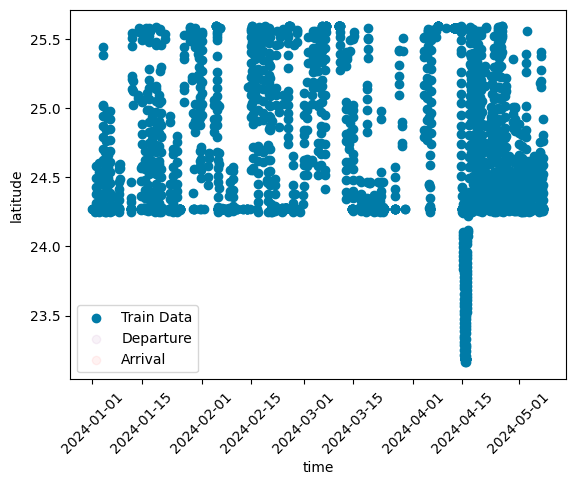

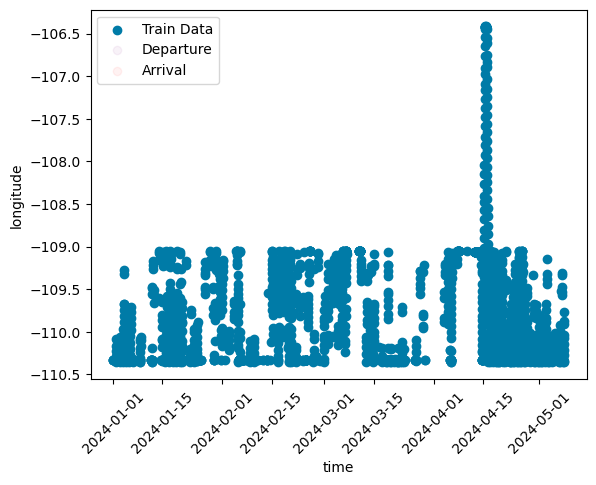

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude


In [92]:
# Filter the same vessel entries in ais_train and ais_test
def plotVessel(vessel_id='61e9f3aeb937134a3c4bfe3d', feature='latitude'):
    train_vessel = ais_train[ais_train['vesselId'] == vessel_id]
    schedule = schedules_to_may_2024[schedules_to_may_2024['vesselId'] == vessel_id]
    # remove entries from schedule that are earlier than the first entry in ais_train
    schedule = schedule[schedule['sailingDate'] > train_vessel['time'].min()]
    # Plot latitude vs time for ais_train as a scatter plot
    plt.scatter(train_vessel['time'], train_vessel[feature], label='Train Data', color='#007BA7')
    " Plot blue dots for the depature dates and dark bliue for the arrival dates"
    plt.scatter(schedule['sailingDate'], schedule['portLatitude'], label='Departure', color='purple', alpha=0.05)
    # Semitransparent dots for the arrival dates
    plt.scatter(schedule['arrivalDate'], schedule['portLatitude'], label='Arrival', color='red', alpha=0.05)
    plt.xticks(rotation=45)
    plt.xlabel('time')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

plotVessel(vessel_id='61e9f468b937134a3c4c028f')
plotVessel(vessel_id='61e9f468b937134a3c4c028f', feature='longitude')
schedules_to_may_2024[schedules_to_may_2024['vesselId'] == '61e9f468b937134a3c4c028f'].head()
#plotVessel(feature='longitude')

In [93]:
vesselsIdsToPredict = ['61e9f468b937134a3c4c028f']
vesselsToPredict = ais_train[ais_train['vesselId'].isin(vesselsIdsToPredict)]
vesselsToPredict.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
5,2024-01-01 00:05:13,186.90,0.00,0,187,5,2023-12-20 02:40:00,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a
521,2024-01-01 01:17:15,186.90,0.00,0,187,5,2023-12-20 02:40:00,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a
860,2024-01-01 01:59:15,186.90,0.00,0,187,5,2023-12-20 02:40:00,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a
1178,2024-01-01 02:47:14,186.80,0.00,0,187,5,2023-12-20 02:40:00,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a
1621,2024-01-01 03:35:14,186.90,0.00,0,187,5,2023-12-20 02:40:00,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a


## Feature Engineering

In [94]:
ais_train_FE = vesselsToPredict.copy()

# Print what type ais_train_FE['time'] is¨
print(type(ais_train_FE['time']))


# Add feature to ais_train_FE, hours since last timestamp, 0 if first timestamp
ais_train_FE['hoursPassed'] = (ais_train_FE['time'].diff().dt.total_seconds() / 3600).fillna(0)
ais_train_FE['hoursToEda'] = ((ais_train_FE['etaRaw'] - ais_train_FE['time']).dt.total_seconds() / 3600).fillna(0)

# print nr of rows
print(ais_train_FE.shape)

# remove etaRaw
ais_train_FE = ais_train_FE.drop(columns='etaRaw')

# split ais_train_FE into train and test, using the last 5 days as test, sorting by time first
ais_train_FE = ais_train_FE.sort_values('time')
ais_train_FE_train = ais_train_FE[ais_train_FE['time'] < ais_train_FE['time'].max() - pd.Timedelta(days=10)]
ais_train_FE_test = ais_train_FE[ais_train_FE['time'] >= ais_train_FE['time'].max() - pd.Timedelta(days=10)]

print(ais_train_FE_train.shape)
print(ais_train_FE_test.shape)
ais_train_FE_train.head()


<class 'pandas.core.series.Series'>
(2291, 13)
(1949, 12)
(342, 12)


,time,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,hoursPassed,hoursToEda
5,2024-01-01 00:05:13,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,0.00,-285.42
521,2024-01-01 01:17:15,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,1.20,-286.62
860,2024-01-01 01:59:15,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,0.70,-287.32
1178,2024-01-01 02:47:14,186.80,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,0.80,-288.12
1621,2024-01-01 03:35:14,186.90,0.00,0,187,5,24.27,-110.33,61e9f468b937134a3c4c028f,61d37ac11366c3998241da0a,0.80,-288.92


In [98]:
"""
from prophet import Prophet
from xgboost import XGBRegressor
import pandas as pd

# Step 1: Modify Prophet to include extra regressors (hoursPassed, hoursToEda)
def train_prophet_with_regressors(df, feature, time_column='time', regressors=['hoursPassed', 'hoursToEda']):
    # Prepare the data for Prophet
    df_prophet = df[[time_column, feature] + regressors].rename(columns={time_column: 'ds', feature: 'y'})
    
    # Initialize Prophet model
    model = Prophet()
    
    # Add extra regressors
    for reg in regressors:
        model.add_regressor(reg)
    
    # Fit the Prophet model
    model.fit(df_prophet)
    
    # Forecast future values (use test set regressors)
    future = df_prophet[['ds'] + regressors]
    forecast = model.predict(future)
    
    # Return the forecast including the regressors
    return forecast[['ds', 'yhat']].rename(columns={'yhat': feature})

# Step 2: Use Prophet to predict each feature, including regressors
features = ['cog', 'sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude']
regressors = ['hoursPassed', 'hoursToEda']

prophet_predictions = {}

for feature in features:
    prophet_predictions[feature] = train_prophet_with_regressors(ais_train_FE_train, feature, regressors=regressors)

# Step 3: Calculate residuals (actual - predicted)
residuals = pd.DataFrame()

for feature in features:
    residuals[feature] = ais_train_FE_train[feature] - prophet_predictions[feature][feature]

# Step 4: Train XGBoost on residuals, including extra regressors
xgb_model = XGBRegressor()
xgb_model.fit(ais_train_FE_train[features + regressors], residuals[features])

# Step 5: Prophet predictions on test set (with regressors)
final_predictions = ais_train_FE_test[['time', 'hoursPassed', 'hoursToEda']].copy()

for feature in features:
    prophet_test_predictions = train_prophet_with_regressors(ais_train_FE_test, feature, regressors=regressors)
    final_predictions[feature] = prophet_test_predictions[feature]

# Step 6: Predict residuals using XGBoost (with regressors)
residual_preds = xgb_model.predict(ais_train_FE_test[features + regressors])

# Step 7: Add residuals back to Prophet predictions
final_predictions[features] += residual_preds

# Output the final predictions
print(final_predictions.head())
"""



"\nfrom prophet import Prophet\nfrom xgboost import XGBRegressor\nimport pandas as pd\n\n# Step 1: Modify Prophet to include extra regressors (hoursPassed, hoursToEda)\ndef train_prophet_with_regressors(df, feature, time_column='time', regressors=['hoursPassed', 'hoursToEda']):\n    # Prepare the data for Prophet\n    df_prophet = df[[time_column, feature] + regressors].rename(columns={time_column: 'ds', feature: 'y'})\n    \n    # Initialize Prophet model\n    model = Prophet()\n    \n    # Add extra regressors\n    for reg in regressors:\n        model.add_regressor(reg)\n    \n    # Fit the Prophet model\n    model.fit(df_prophet)\n    \n    # Forecast future values (use test set regressors)\n    future = df_prophet[['ds'] + regressors]\n    forecast = model.predict(future)\n    \n    # Return the forecast including the regressors\n    return forecast[['ds', 'yhat']].rename(columns={'yhat': feature})\n\n# Step 2: Use Prophet to predict each feature, including regressors\nfeatures = 

In [103]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

